In [8]:
import os
os.add_dll_directory('D:/python/anaconda/envs/camelyon/openslide-bin-4.0.0.3-windows-x64/bin')
import openslide

In [2]:
import h5py
import torch
import pandas as pd

In [3]:
# 定义加载数据和标签的函数,从HDF5文件中加载数据和标签，并将它们转换为PyTorch张量
def load_h5_data(file_path):
    with h5py.File(file_path, 'r') as file:
        return torch.tensor(file['x'][:])

def load_h5_labels(file_path):
    with h5py.File(file_path, 'r') as file:
        return torch.tensor(file['y'][:])

# 加载CSV文件的函数
def load_csv(file_path):
    return pd.read_csv(file_path)

In [4]:
# 加载数据 
# train data
train_x = load_h5_data('data/camelyonpatch_level_2_split_train_x.h5')
train_y = load_h5_labels('data/camelyonpatch_level_2_split_train_y.h5')
train_meta = load_csv('data/camelyonpatch_level_2_split_train_meta.csv')

# valid data
valid_x = load_h5_data('data/camelyonpatch_level_2_split_valid_x.h5')
valid_y = load_h5_labels('data/camelyonpatch_level_2_split_valid_y.h5')
valid_meta = load_csv('data/camelyonpatch_level_2_split_valid_meta.csv')

# test data
test_x = load_h5_data('data/camelyonpatch_level_2_split_test_x.h5')
test_y = load_h5_labels('data/camelyonpatch_level_2_split_test_y.h5')
test_meta = load_csv('data/camelyonpatch_level_2_split_test_meta.csv') 

In [5]:
print("Train:", train_x.shape, train_y.shape)
print("Valid:", valid_x.shape, valid_y.shape)
print("Test:", test_x.shape, test_y.shape)
print("Train meta shape:", train_meta.shape)
print("Validation meta shape:", valid_meta.shape)
print("Test meta shape:", test_meta.shape)

Train: torch.Size([262144, 96, 96, 3]) torch.Size([262144, 1, 1, 1])
Valid: torch.Size([32768, 96, 96, 3]) torch.Size([32768, 1, 1, 1])
Test: torch.Size([32768, 96, 96, 3]) torch.Size([32768, 1, 1, 1])
Train meta shape: (262144, 6)
Validation meta shape: (32768, 6)
Test meta shape: (32768, 6)


In [6]:
# 查看训练标签的唯一值和计数
unique_labels, counts = torch.unique(train_y, return_counts=True)
label_distribution = dict(zip(unique_labels.tolist(), counts.tolist()))
print("Train label distribution:", label_distribution)

# 查看元数据的信息
print("Train meta info:")
print(train_meta.head())


Train label distribution: {0: 131072, 1: 131072}
Train meta info:
   Unnamed: 0  coord_y  coord_x  tumor_patch  center_tumor_patch  \
0           0    63104    43648        False               False   
1           1   148544    74048         True                True   
2           2    64192    78912         True                True   
3           3    98048    72128         True                True   
4           4    27264    50688        False               False   

                           wsi  
0   camelyon16_train_tumor_104  
1   camelyon16_train_tumor_003  
2   camelyon16_train_tumor_089  
3   camelyon16_train_tumor_004  
4  camelyon16_train_normal_118  


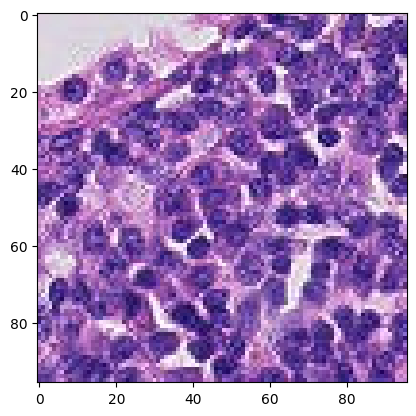

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 定义加载数据的函数
def load_h5_image(file_path, dataset_name):
    with h5py.File(file_path, 'r') as file:
        images = np.array(file[dataset_name])  # 确认数据集名称
    return images

# 加载图像数据
train_images = load_h5_image('D:/【Applied statistics 】/dessertation/dissertation_camelyon-1/data/camelyonpatch_level_2_split_train_x.h5', 'x')  # 替换为你的文件路径和数据集键名

# 显示第一张图像
plt.imshow(train_images[0])
plt.show()


数据预处理

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

class H5Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels.view(-1)  # 调整标签形状为 [样本数]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].permute(2, 0, 1)  # 调整图像形状为 [通道数, 高度, 宽度]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 定义数据增强和归一化
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 创建训练和验证数据集
train_dataset = H5Dataset(train_x, train_y, transform=transform)
valid_dataset = H5Dataset(valid_x, valid_y, transform=transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


模型

In [11]:
# 加载预训练的 GoogLeNet 模型
model = models.googlenet(pretrained=True)

# 微调最后一层
model.fc = nn.Linear(model.fc.in_features, 2)  # 假设有2个分类

# 使用GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # 清空梯度
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # 验证模型
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Accuracy: {100 * correct / total} %')


d:\python\anaconda\envs\camelyon\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


KeyboardInterrupt: 